# Analysis

This notebook analysis the results of the FL experiments, beginning with the first stage results. It will not only contain code and graphics, but also text describing the findings. This is in order to find the proper direction of research and to make writing the thesis chapter more easier afterwards.
The first stage analyses a wide range of FL models. The idea is to find similarities and differences between them. Therefore, this part heavily emphasizes on desprictive statistics of the collection of results.
The second stage focuses on specific results. The underlying model is more examined and potentential reasons for the unusual performances are considered. 

## Stage One - A Broad View on the Results 

In [1]:
#import libraries
import numpy as np
import pandas as pd

import tensorflow as tf
import sklearn as sk

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

2023-02-10 12:48:57.960202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 12:49:00.352718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-10 12:49:00.352853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-10 12:49:00.352862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#load data
df = pd.read_json("../logs.json")
df.head()

,date,model,dataset,rounds,losses_distributed,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers
0,1970-01-01,linear regression,weather,2,"[[1, 0.2226459577], [2, 0.2234555605]]","[[1, 10576.5143687], [2, 10576.5348202]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
1,1970-01-01,linearSVR,weather,2,"[[1, 0.2140126819], [2, 0.21787175820000002]]","[[1, 10586.9262073], [2, 10586.9975151]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
2,1970-01-01,MLP,weather,2,"[[1, 0.2242389992], [2, 0.2104952633]]","[[1, 10601.58299], [2, 10604.0674518]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2
3,1970-01-01,MLP,weather,2,"[[1, 0.21910745650000002], [2, 0.2258445099000...","[[1, 10617.884518], [2, 10619.4994774]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2
4,1970-01-01,MLP,weather,2,"[[1, 0.2284888551], [2, 0.22254440190000002]]","[[1, 10634.7649193], [2, 10638.9479927]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,3


In [3]:
#print information
print(f"""
Length: {len(df.index)}
Covid entries: {len(df[df.dataset == "covid"].index)}
Weather entries: {len(df[df.dataset == "weather"].index)}
Contains Nans: {df.isnull().values.any()}
""")


Length: 223
Covid entries: 72
Weather entries: 151
Contains Nans: False



In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rounds,223.0,3.964126,2.802599e+00,2.0,2.0,2.0,4.0,10.0
number_of_clients,223.0,3.004484,1.002240e+00,2.0,2.0,4.0,4.0,4.0
entries,223.0,10.000000,0.000000e+00,10.0,10.0,10.0,10.0,10.0
number_of_samples,223.0,39058.295964,4.217628e+04,10000.0,10000.0,10000.0,100000.0,100000.0
percentage_of_testing_data,223.0,0.200000,2.781802e-17,0.2,0.2,0.2,0.2,0.2
epochs,223.0,7.452915,3.735184e+00,2.0,2.0,10.0,10.0,10.0
hidden_layers,223.0,3.071749,8.874805e-01,2.0,2.0,3.0,4.0,5.0


The next part examines characteristics of each use case. 

### Weather dataset

In [5]:
#get horizontal use case
weather_df = df[df.dataset == "weather"]

In [6]:
#print general information
print(f"""
Linear Regression entries: {len(weather_df[weather_df.model == "linear regression"].index)}
LinearSVR entries: {len(weather_df[weather_df.model == "linearSVR"].index)}
MLP entries: {len(weather_df[weather_df.model == "MLP"].index)}
LSTM entries: {len(weather_df[weather_df.model == "LSTM"].index)}
CNN entries: {len(weather_df[weather_df.model == "CNN"].index)}
""")


Linear Regression entries: 4
LinearSVR entries: 4
MLP entries: 47
LSTM entries: 48
CNN entries: 48



The first interesting is to see how well the best model of every algorithm performed.

In [7]:
models = ["linear regression", "linearSVR", "MLP", "LSTM", "CNN"]
best_weather_performance = pd.DataFrame(columns=weather_df.columns)
for i, model in enumerate(models):
    df_copy = weather_df[weather_df.model == model].copy(deep=True)
    df_copy["losses_distributed"] = df_copy["losses_distributed"].apply(lambda x: x[-1][-1])
    best_weather_performance = pd.concat([best_weather_performance, df_copy.sort_values(by=["losses_distributed"], ascending=True).iloc[0:1, :]], ignore_index=True)

best_weather_performance.head()
    

,date,model,dataset,rounds,losses_distributed,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers
0,1970-01-01,linear regression,weather,4,0.217215,"[[1, 11919.1425425], [2, 11919.1607451], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
1,1970-01-01,linearSVR,weather,4,0.217683,"[[1, 11929.5103741], [2, 11929.5911009], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
2,1970-01-01,MLP,weather,4,0.182570,"[[1, 12347.0479739], [2, 12356.8283852], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,4
3,1970-01-01,LSTM,weather,4,0.206540,"[[1, 12775.0664505], [2, 12805.5933949], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,2
4,1970-01-01,CNN,weather,4,0.198107,"[[1, 20000.5160829], [2, 20014.6342996], [3, 2...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,3


The results match the expectations. The linear models can understand the underlying structure of the data. But the neural-network based models more capable in adapting to it. Interestingly, the MLP had the best performance. But in general the differences are minor.

<AxesSubplot: xlabel='model', ylabel='losses_distributed'>

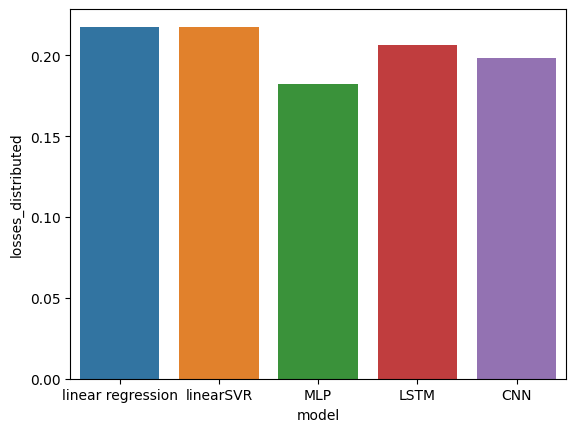

In [8]:
sns.barplot(data=best_weather_performance, x="model", y="losses_distributed")

What is the average performance?

In [9]:
average_weather_performance = {"linear regression": 0, "linearSVR": 0, "MLP": 0, "LSTM": 0, "CNN": 0}
for  model in models:
    df_copy = weather_df[weather_df.model == model].copy(deep=True)
    df_copy["losses_distributed"] = df_copy["losses_distributed"].apply(lambda x: x[-1][-1])
    #print(df_copy["losses_distributed"].mean())
    average_weather_performance[model] = df_copy["losses_distributed"].mean()

average_weather_performance = pd.DataFrame(list(average_weather_performance.items()), columns=["model", "losses_distributed"])

<AxesSubplot: xlabel='model', ylabel='losses_distributed'>

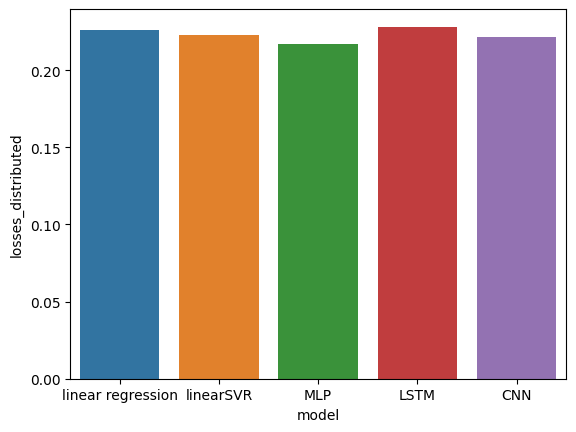

In [10]:
sns.barplot(average_weather_performance, x="model", y="losses_distributed")

The models performed almost identically on average. Next, it is interesting to see the variation in the data. Every record has a different parameter configuration. How "robust" are the algorithms?

In [11]:
results_only_df = weather_df.copy(deep=True)
results_only_df["losses_distributed"] = results_only_df["losses_distributed"].apply(lambda x: x[-1][-1])
results_only_df.head()

,date,model,dataset,rounds,losses_distributed,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers
0,1970-01-01,linear regression,weather,2,0.223456,"[[1, 10576.5143687], [2, 10576.5348202]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
1,1970-01-01,linearSVR,weather,2,0.217872,"[[1, 10586.9262073], [2, 10586.9975151]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
2,1970-01-01,MLP,weather,2,0.210495,"[[1, 10601.58299], [2, 10604.0674518]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2
3,1970-01-01,MLP,weather,2,0.225845,"[[1, 10617.884518], [2, 10619.4994774]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2
4,1970-01-01,MLP,weather,2,0.222544,"[[1, 10634.7649193], [2, 10638.9479927]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,3


<AxesSubplot: xlabel='losses_distributed', ylabel='model'>

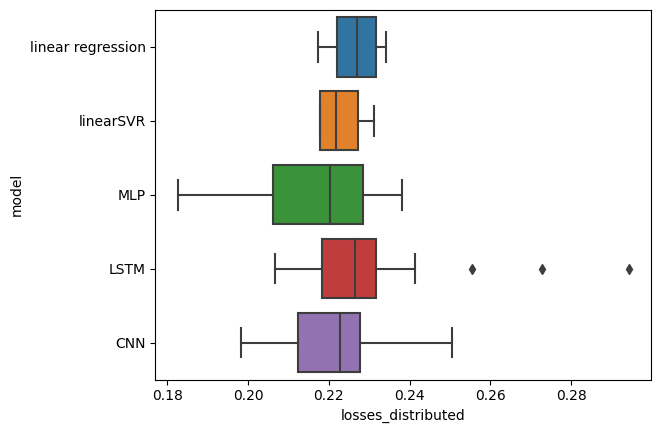

In [12]:
sns.boxplot(data=results_only_df, x="losses_distributed", y="model")

How big is the difference between two and four clients?

In [13]:
print(f"""
Entries for two clients: {len(weather_df[weather_df.number_of_clients == 2].index)}
Entries for four clients: {len(weather_df[weather_df.number_of_clients == 4].index)}
""")


Entries for two clients: 75
Entries for four clients: 76



<AxesSubplot: ylabel='Density'>

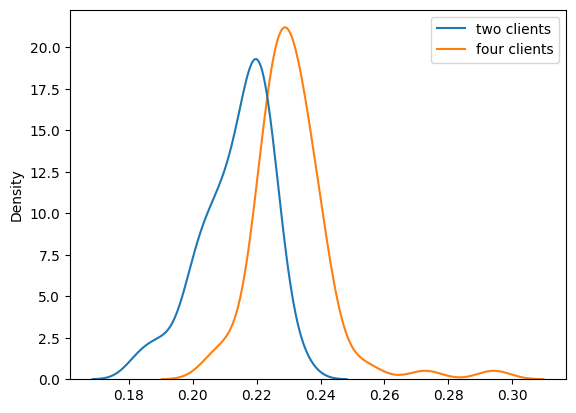

In [14]:
two_clients_df = results_only_df[results_only_df.number_of_clients == 2]
four_clients_df = results_only_df[results_only_df.number_of_clients == 4]

num_of_clients_diff_df = pd.DataFrame({"two clients": two_clients_df.losses_distributed, "four clients": four_clients_df.losses_distributed})

sns.kdeplot(num_of_clients_diff_df)

It looks like more clients acutally worsened the results. Do the number of rounds impact the model performance?

<AxesSubplot: ylabel='Density'>

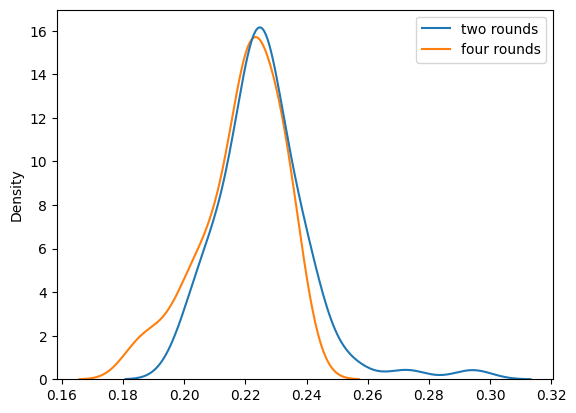

In [15]:
two_rounds_df = results_only_df[results_only_df.rounds == 2]
four_rounds_df = results_only_df[results_only_df.rounds == 4]

num_of_rounds_diff_df = pd.DataFrame({"two rounds": two_rounds_df.losses_distributed, "four rounds": four_rounds_df.losses_distributed})

sns.kdeplot(num_of_rounds_diff_df)

The number of rounds seems to have an impact on performance. The average is almost the same, but the tails are different. Four rounds has a fat tail on the left, while the two rounds distribution has one on the right. What the skew and kurosis of the distributions?

In [16]:
print(f"""
Two rounds skew: {two_rounds_df.losses_distributed.skew()}
Two rounds kurosis: {two_rounds_df.losses_distributed.kurtosis()}
Four rounds skew: {four_rounds_df.losses_distributed.skew()}
Four rounds kurtosis: {four_rounds_df.losses_distributed.kurtosis()}
""")


Two rounds skew: 1.5693143204844295
Two rounds kurosis: 5.696400153934413
Four rounds skew: -0.8485354721781264
Four rounds kurtosis: 0.2908048777307082



Training with two rounds creates a left-skewed distribution with a high kurosis of around 5.7. It has an excess kurtosis of 2.7 and is therefore leptokurtic.
Training with four rounds creates a slightly right-skewed distribution and has a small negative kurtosis of around 0.3.

Next, let's look at the average training time.

In [17]:
def calculate_training_time(time_array):
    #get the timestamps
    timestamps = []
    for el in time_array:
        timestamps.append(el[-1])
    
    #calculate difference
    diff = []
    for i in range(len(timestamps)):
        if i == len(timestamps)-1:
            break
        diff.append((timestamps[i+1] - timestamps[i]))
    return diff

time_diff_df = weather_df.copy(deep=True)
time_diff_df["time"] = time_diff_df["time"].apply(calculate_training_time)

In [18]:
time_average_df = time_diff_df
time_average_df["time"] = time_average_df["time"].apply(lambda x: np.array(x).mean())

In [19]:
average_time_performance = {"linear regression": 0, "linearSVR": 0, "MLP": 0, "LSTM": 0, "CNN": 0}
for  model in models:
    df = time_average_df[time_average_df.model == model]
    average_time_performance[model] = df["time"].mean()

average_time_performance = pd.DataFrame(list(average_time_performance.items()), columns=["model", "time"])
average_time_performance.head()

,model,time
0,linear regression,0.023744
1,linearSVR,0.061238
2,MLP,7.355131
3,LSTM,23.770155
4,CNN,7.257786


<AxesSubplot: xlabel='model', ylabel='time'>

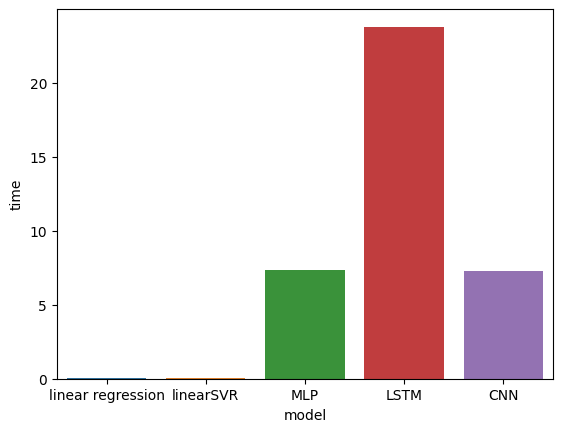

In [20]:
sns.barplot(average_time_performance, x="model", y="time")

In [21]:
print(f'The training of a linear regression model is {average_time_performance.time.iloc[3] / average_time_performance.time.iloc[0]} times faster than that of a LSTM.')

The training of a linear regression model is 1001.1173724721822 times faster than that of a LSTM.


How big is the variance in training time?

<AxesSubplot: xlabel='time', ylabel='model'>

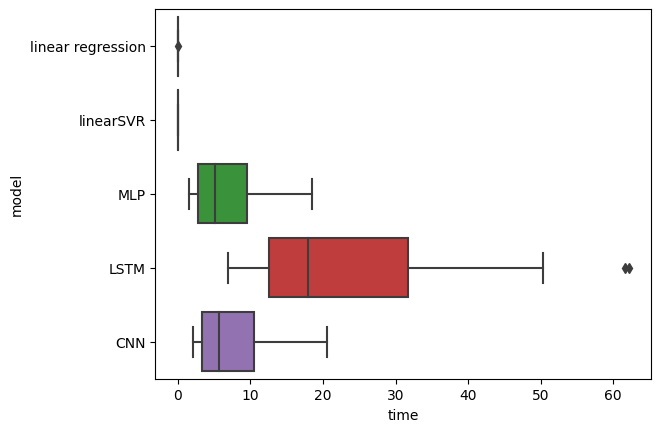

In [22]:
sns.boxplot(data=time_diff_df, x="time", y="model")

Now lets compare the models with the baseline. First, all FL models are compared to the baselines. It is likely they perform worse on average because of their hyperparameters. After that the best models, as well as the models with optimal hyperparameters are selected, trained multiple times to minimize the effect of random initialization and then compared. 

In [23]:
import json

with open('exports/weather_baselines.json') as data:
    baselines = json.load(data)
    data.close()

In [24]:
dfs = []
for model, data in baselines.items():
    df = pd.DataFrame.from_dict(data)
    df['model'] = model
    dfs.append(df)

baseline_df = pd.concat(dfs, axis=0, ignore_index=True)
baseline_df.head()

,client_data1,client_time1,client_data2,client_time2,client_data3,client_time3,client_data4,client_time4,model
0,0.222270,0.010939,0.223302,0.016511,0.224021,0.021223,0.230759,0.012161,linear_regression
1,0.222270,0.015447,0.223302,0.019307,0.224021,0.029146,0.230759,0.014056,linear_regression
2,0.222270,0.015393,0.223302,0.014606,0.224021,0.015327,0.230759,0.021031,linear_regression
3,0.222270,0.015276,0.223302,0.013431,0.224021,0.015049,0.230759,0.016273,linear_regression
4,0.211783,0.152862,0.216020,0.163486,0.218518,0.179039,0.225282,0.163869,linearSVR


In [25]:
baseline_averages = baseline_df.groupby("model").mean()
baseline_averages

,client_data1,client_time1,client_data2,client_time2,client_data3,client_time3,client_data4,client_time4
model,,,,,,,,
CNN,0.215252,11.871319,0.219829,12.152645,0.223448,11.863196,0.233304,13.173181
LSTM,0.214183,31.722968,0.219383,33.467527,0.224335,33.840387,0.225936,29.083344
MLP,0.227788,13.465819,0.233096,12.574851,0.227681,12.460185,0.234444,13.460793
linearSVR,0.211739,0.163347,0.215972,0.151038,0.218478,0.170436,0.225334,0.179029
linear_regression,0.222270,0.014264,0.223302,0.015964,0.224021,0.020186,0.230759,0.015880


<AxesSubplot: ylabel='Density'>

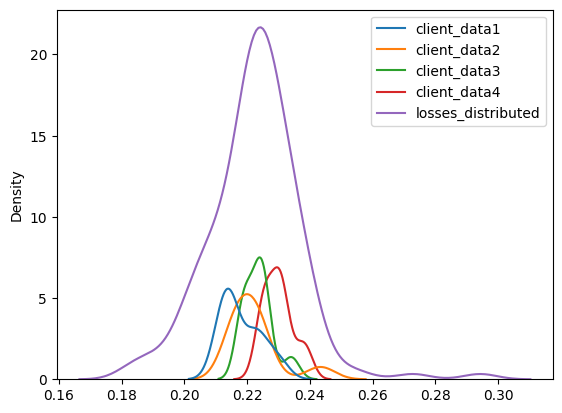

In [26]:
temp_df = baseline_df.copy(deep=True)
temp_df["model"] = temp_df["model"].apply(lambda x: f'{x} basline')
#fig = sns.boxplot(temp_df, x="client_data4", y="model")
#fig = sns.boxplot(results_only_df, x="losses_distributed", y="model")
#plt.show()

fig, ax = plt.subplots()
sns.kdeplot(data=[temp_df["client_data1"], temp_df["client_data2"], temp_df["client_data3"], temp_df["client_data4"], results_only_df["losses_distributed"]], ax=ax)

In [27]:
print(f"""
Mean baseline for data of 1 client: {baseline_averages["client_data1"].mean()}
Mean baseline for data of 2 clients: {baseline_averages["client_data2"].mean()}
Mean baseline for data of 3 clients: {baseline_averages["client_data3"].mean()}
Mean baseline for data of 4 clients: {baseline_averages["client_data4"].mean()}
------------------------------------------------------------------------------
Mean for FL with 2 clients:{two_rounds_df["losses_distributed"].mean()}
Mean for FL with 4 clients: {four_rounds_df["losses_distributed"].mean()}
""")


Mean baseline for data of 1 client: 0.21824637307409445
Mean baseline for data of 2 clients: 0.22231626565889617
Mean baseline for data of 3 clients: 0.22359249364146358
Mean baseline for data of 4 clients: 0.2299554985734487
------------------------------------------------------------------------------
Mean for FL with 2 clients:0.22584150387105262
Mean for FL with 4 clients: 0.2188825170266667



The data suggests that combining data from multiple weather stations and training them centrally actually decreases the accuracy of the model. This does not seem to be the case for the FL setting. How does the skewness and kurosis looks for the distributions?

In [28]:
baseline_fl_dist_df = pd.DataFrame(([["Baseline 1 clients data", baseline_averages["client_data1"].mean(), baseline_averages["client_data1"].std(), baseline_averages["client_data1"].skew(), baseline_averages["client_data1"].kurtosis()],
    ["Baseline 2 clients data", baseline_averages["client_data2"].mean(), baseline_averages["client_data2"].std(), baseline_averages["client_data2"].skew(), baseline_averages["client_data2"].kurtosis()],
    ["Baseline 3 clients data", baseline_averages["client_data3"].mean(), baseline_averages["client_data3"].std(), baseline_averages["client_data3"].skew(), baseline_averages["client_data3"].kurtosis()],
    ["Baseline 4 clients data", baseline_averages["client_data4"].mean(), baseline_averages["client_data4"].std(), baseline_averages["client_data4"].skew(), baseline_averages["client_data4"].kurtosis()],
    ["FL with 2 clients", two_rounds_df["losses_distributed"].mean(), two_rounds_df["losses_distributed"].std(), two_rounds_df["losses_distributed"].skew(), two_rounds_df["losses_distributed"].kurtosis()],
    ["FL with 4 clients", four_rounds_df["losses_distributed"].mean(), four_rounds_df["losses_distributed"].std(), four_rounds_df["losses_distributed"].skew(), four_rounds_df["losses_distributed"].kurtosis()]
]), columns=["scenario", "mean", "std", "skew", "kurtosis"])

baseline_fl_dist_df

,scenario,mean,std,skew,kurtosis
0,Baseline 1 clients data,0.218246,0.006615,0.812232,-1.018635
1,Baseline 2 clients data,0.222316,0.006561,1.412421,2.274488
2,Baseline 3 clients data,0.223592,0.003303,-0.751865,2.128932
3,Baseline 4 clients data,0.229955,0.004169,-0.202155,-2.830588
4,FL with 2 clients,0.225842,0.014977,1.569314,5.696400
5,FL with 4 clients,0.218883,0.013250,-0.848535,0.290805


In [29]:
time_diff_df.head()

,date,model,dataset,rounds,losses_distributed,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers
0,1970-01-01,linear regression,weather,2,"[[1, 0.2226459577], [2, 0.2234555605]]",0.020452,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
1,1970-01-01,linearSVR,weather,2,"[[1, 0.2140126819], [2, 0.21787175820000002]]",0.071308,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
2,1970-01-01,MLP,weather,2,"[[1, 0.2242389992], [2, 0.2104952633]]",2.484462,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2
3,1970-01-01,MLP,weather,2,"[[1, 0.21910745650000002], [2, 0.2258445099000...",1.614959,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2
4,1970-01-01,MLP,weather,2,"[[1, 0.2284888551], [2, 0.22254440190000002]]",4.183073,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,3


## Stage Two - Comparing the Performances to the Baselines

This section compares the baselines to individual FL model configurations. Two types of FL configurations are considered. The first one uses the same hyperparameters as the baselines, the second one are the models with the best recorded loss. Every FL model gets trained five times again to minimize the effect of random initialization.

In [30]:
fl_models_df = pd.read_json("../weather_best_model_logs.json")

best_fl_models = fl_models_df.iloc[:20]
optimal_fl_models = fl_models_df.iloc[20:]

In [31]:
optimal_fl_models.head()

,date,model,dataset,rounds,losses_distributed,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers
20,1970-01-01 00:00:00.000000000,MLP,weather,4,"[[1, 0.21519848700000002], [2, 0.2005374432], ...","[[1, 14980.6917905], [2, 14999.3559206], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
21,1970-01-01 00:00:00.000000000,MLP,weather,4,"[[1, 0.2116634026], [2, 0.2057350501], [3, 0.1...","[[1, 15065.6413317], [2, 15084.2653377], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
22,1970-01-01 00:00:00.000000000,MLP,weather,4,"[[1, 0.2174249068], [2, 0.2002970204], [3, 0.1...","[[1, 15151.7634301], [2, 15170.2976487], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
23,1970-01-01 00:00:00.000000000,MLP,weather,4,"[[1, 0.2144285068], [2, 0.2090328783], [3, 0.1...","[[1, 15236.8261356], [2, 15255.6471677], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
24,1970-01-01 00:00:00.000000001,CNN,weather,4,"[[1, 0.2160531953], [2, 0.21621894090000002], ...","[[1, 15317.5592742], [2, 15331.1331537], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,4


In [32]:
baseline_df.head()

,client_data1,client_time1,client_data2,client_time2,client_data3,client_time3,client_data4,client_time4,model
0,0.222270,0.010939,0.223302,0.016511,0.224021,0.021223,0.230759,0.012161,linear_regression
1,0.222270,0.015447,0.223302,0.019307,0.224021,0.029146,0.230759,0.014056,linear_regression
2,0.222270,0.015393,0.223302,0.014606,0.224021,0.015327,0.230759,0.021031,linear_regression
3,0.222270,0.015276,0.223302,0.013431,0.224021,0.015049,0.230759,0.016273,linear_regression
4,0.211783,0.152862,0.216020,0.163486,0.218518,0.179039,0.225282,0.163869,linearSVR


How well have the FL models preformed compared to the baseline? 

In [33]:
def rename_baseline_models(x):
    if x == "linear_regression":
        return "linear regression baseline"
    elif x == "linearSVR":
        return "linearSVR baseline"
    elif x == "MLP":
        return "MLP baseline"
    elif x == "LSTM":
        return "LSTM baseline"
    else:
        return "CNN baseline"

temp_df = baseline_df.copy(deep=True)
temp_df["model"] = temp_df["model"].apply(rename_baseline_models)
temp_df = temp_df[["model", "client_data4"]]
temp_df.columns = ["model", "losses_distributed"]

results_only_best_fl_df = best_fl_models.copy(deep=True)
results_only_best_fl_df["losses_distributed"] = results_only_best_fl_df["losses_distributed"].apply(lambda x: x[-1][-1])
results_only_best_fl_df["model"] = results_only_best_fl_df["model"].apply(lambda x: f"best FL {x}")



results_only_optimal_fl_df = optimal_fl_models.copy(deep=True)
results_only_optimal_fl_df["losses_distributed"] = results_only_optimal_fl_df["losses_distributed"].apply(lambda x: x[-1][-1])
results_only_optimal_fl_df["model"] = results_only_optimal_fl_df["model"].apply(lambda x: f"optimal FL {x}")


In [34]:
temp_df = pd.concat([temp_df, results_only_best_fl_df, results_only_optimal_fl_df], ignore_index=True)

In [35]:
temp_df = temp_df[["model", "losses_distributed"]]
temp_df.columns = ["model", "loss"]

<AxesSubplot: xlabel='loss', ylabel='model'>

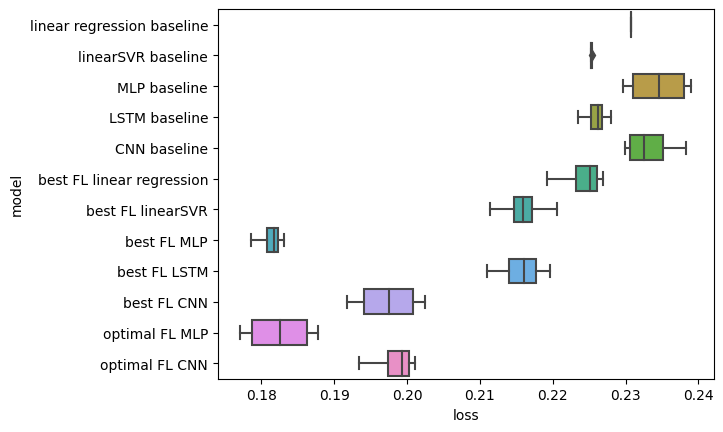

In [36]:
sns.boxplot(temp_df, x="loss", y="model")

The all FL models beat the baseline models. The FL MLPs and CNNs are also really interesting. "best FL MLP/CNN" hyperparameters are based on the best performing models during the FL test run. "optimal FL MLP/CNN" are use the optimal hyperparameters found by the centralized hyperparameter tuning. The difference between the models is only minimal, despite them having a different amount of hidden layers, and likely due to the random initialization. The "optimal FL MLP" is a little better than "best FL MLP" but has a higher variance.

It seems FL produces better models than centralized training with multiple combined datasets. How well does FL perform when compared to centralized training with less combined datasets? 

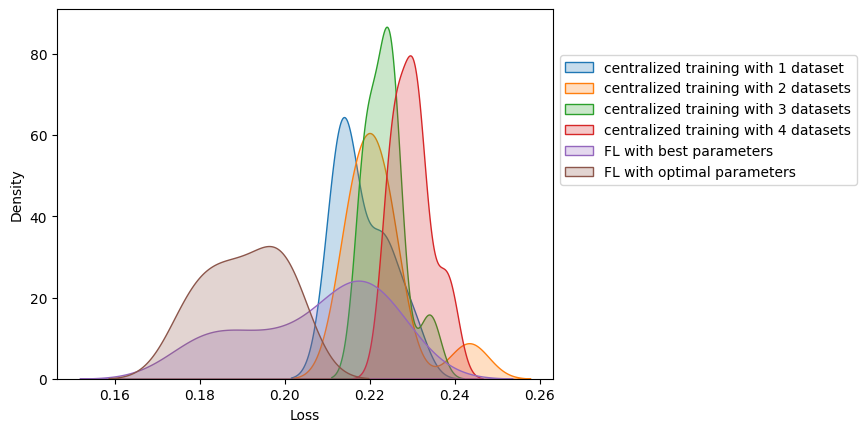

In [37]:
fig = sns.kdeplot(baseline_df["client_data1"], fill=True, label="centralized training with 1 dataset")
fig = sns.kdeplot(baseline_df["client_data2"], fill=True, label="centralized training with 2 datasets")
fig = sns.kdeplot(baseline_df["client_data3"], fill=True, label="centralized training with 3 datasets")
fig = sns.kdeplot(baseline_df["client_data4"], fill=True, label="centralized training with 4 datasets")
fig = sns.kdeplot(results_only_best_fl_df["losses_distributed"], fill=True, label="FL with best parameters")
fig = sns.kdeplot(results_only_optimal_fl_df["losses_distributed"], fill=True, label="FL with optimal parameters")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xlabel("Loss")
plt.show()

In [40]:
best_optimal_fl_dist_df = pd.DataFrame(([
    ["FL with best parameters", results_only_best_fl_df["losses_distributed"].mean(), results_only_best_fl_df["losses_distributed"].std(), results_only_best_fl_df["losses_distributed"].skew(), results_only_best_fl_df["losses_distributed"].kurtosis()],
    ["FL with optimal parameters", results_only_optimal_fl_df["losses_distributed"].mean(), results_only_optimal_fl_df["losses_distributed"].std(), results_only_optimal_fl_df["losses_distributed"].skew(), results_only_optimal_fl_df["losses_distributed"].kurtosis()]
]), columns=["scenario", "mean", "std", "skew", "kurtosis"])

pd.concat([baseline_fl_dist_df.iloc[:4], best_optimal_fl_dist_df], ignore_index=True)

,scenario,mean,std,skew,kurtosis
0,Baseline 1 clients data,0.218246,0.006615,0.812232,-1.018635
1,Baseline 2 clients data,0.222316,0.006561,1.412421,2.274488
2,Baseline 3 clients data,0.223592,0.003303,-0.751865,2.128932
3,Baseline 4 clients data,0.229955,0.004169,-0.202155,-2.830588
4,FL with best parameters,0.206875,0.016237,-0.594406,-1.110406
5,FL with optimal parameters,0.190411,0.009361,-0.259862,-1.616235


This plot shows clearly the advantage of FL over centralized learning. It also suggests that the hyperparameters found by the hyperparameter tuning are a better choice than that found while performing the tests.

Now, how do the training times look like?

In [41]:
def calculate_training_time(time_array):
    #get the timestamps
    timestamps = []
    for el in time_array:
        timestamps.append(el[-1])
    
    #calculate difference
    diff = []
    for i in range(len(timestamps)):
        if i == len(timestamps)-1:
            break
        diff.append((timestamps[i+1] - timestamps[i]))
    return diff

time_diff_best_fl_df = best_fl_models.copy(deep=True)
time_diff_best_fl_df["time"] = time_diff_best_fl_df["time"].apply(calculate_training_time)
time_diff_best_fl_df["time"] = time_diff_best_fl_df["time"].apply(lambda x: np.array(x).mean())
time_diff_best_fl_df["model"] = time_diff_best_fl_df["model"].apply(lambda x: f"best FL {x}")


time_diff_optimal_fl_df = optimal_fl_models.copy(deep=True)
time_diff_optimal_fl_df["time"] = time_diff_optimal_fl_df["time"].apply(calculate_training_time)
time_diff_optimal_fl_df["time"] = time_diff_optimal_fl_df["time"].apply(lambda x: np.array(x).mean())
time_diff_optimal_fl_df["model"] = time_diff_optimal_fl_df["model"].apply(lambda x: f"optimal FL {x}")

In [47]:
baseline_time_df = pd.DataFrame(columns=["model", "time"])

for i in range(1,5):
    temp_df = baseline_df[["model", f"client_time{i}"]].copy(deep=True)
    temp_df["model"] = temp_df["model"].apply(lambda x: "baseline linear regression" if x == "linear_regression" else f"baseline {x}")
    temp_df.columns = ["model", "time"]

    baseline_time_df = pd.concat([baseline_time_df, temp_df], ignore_index=True)

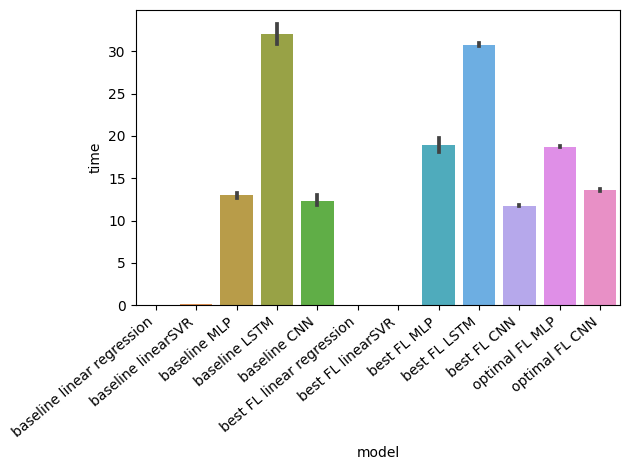

In [53]:
ax = sns.barplot(pd.concat([baseline_time_df, time_diff_best_fl_df, time_diff_optimal_fl_df], ignore_index=True), y="time", x="model")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Linear regression and linearSVR are almost instantly trained, when compared to the neural networks. There doesn't seem to be a clear pattern. The baseline MLP is better than the FL versions, but the LSTM is slightly worse. The rest is very similar to each other. It also important to note that the way of measuring time cannot be implemented the same way for FL and the baselines. Also, this is only a small number of models and therefore not representative for these model architectures.